# Deep Learning for Automatic Case Law Summarization

Shashi Kunapuli, Hillel Landman, Saif Mohammed & Khurram Munawar


<hr style="height:2pt">

In [1]:
import requests
from IPython.display import Image
from IPython.core.display import display, HTML

In [43]:
import sys
import os
import re
import json
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import spacy
from spacy.cli import link
from spacy.util import get_package_path

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

from bs4 import BeautifulSoup 
from gensim.summarization.summarizer import summarize

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Bidirectional, concatenate
from tensorflow.keras.layers import TimeDistributed, RepeatVector, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from datetime import datetime

import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, GPT2Model

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

## I) Introduction

The scope of this project is to produce automated summarization of Case Law by utilizing extractive or abstractive NLP models. Case law is a collection of legal decisions that are used in future cases to determine legal precedents. 

The <a href="https://case.law/">Caselaw Access Project</a> files compiled by Harvard Law School is a corpus of three hundered years worth of Case Law documentation in the United States. For this project North Carolina Case Law files were used as source data.

----------

## II) Data Preprocessing

#### 1) Load data

The dataset loaded for this project contains over 97,000 case law texts from North Carolina since the early 1800s.

In [172]:
data2 = []
with open("data/dataNC2.jsonl") as f:
    for line in f:
        data2.append(json.loads(line))

Certain hyperparameters are established for when the data is preprocessed. Cases are filtered to those only as far back as 1980 in order to capture language that is more relevant to today, and also to reduce processing time for certain functions. Cases are also filtered to include those with a minimum word length of 500 words, and headnotes with a minimum of 100 words.

In [113]:
RECENCY_YEAR = 1980
MIN_WORD_LEN = 500
MIN_HEADNOTE_LEN = 100

#### 2) Filter recent cases

Recent cases are filtered by reading in the year as a datetime object and appending those from 1980 and later to our `recents` list.

In [114]:
dates = [d['decision_date'] for d in data2]

recents = []
date_errors = []
for i, date in enumerate(dates):
    try:
        if datetime.strptime(date, '%Y-%m-%d').year >= RECENCY_YEAR:
            recents.append(data2[i])
    except ValueError:
        date_errors.append(i)

There are just over 38,000 cases from 1980 and later.

In [5]:
len(recents)

38072

#### 3) Extract text elements

Each element of the dataset is formatted as a python dictionary. Within the dictionary, a `data` element contains an XML-formatted body that includes most of the relevant information. Each case includes the case text itself and a section of headnotes. We parse the `data` using BeautifulSoup, extracting texts and headnotes that meet the minimum length hyperparameter specifications.

In [115]:
# Extract raw text elements if body is long enough
raw_text = []
raw_info = []
raw_headnotes = []
errors = 0

for i in range(len(recents)):
    try:
        d = recents[i]
        soup = BeautifulSoup(d['casebody']['data'])
        
        # Check if text/headnotes are long enough
        if len(word_tokenize(' '.join([element.text for element in soup.find_all('p')]))) >= MIN_WORD_LEN:
            if len(word_tokenize(' '.join([element.text for element in soup.find_all('headnotes')]))) >= MIN_HEADNOTE_LEN:
                
                # Append text for each case/headnotes
                raw_text.append(' '.join([element.text for element in soup.find_all('p')]))
                raw_headnotes.append(' '.join([element.text for element in soup.find_all('headnotes')]))

                # Append other info
                raw_info.append([d['name'], d['decision_date'], d['court']['name']])
        
    except IndexError:
        errors += 1
        pass

CPU times: user 10min 37s, sys: 55.1 ms, total: 10min 37s
Wall time: 10min 37s


After this process, just over 19,000 cases remain.

In [7]:
print('Number of Cases: {}'.format(len(raw_text)))

Number of Cases: 19072
Errors: 0


#### 4) Preprocess the Data

To preprocess the data, a preprocessing function is applied. The function accomplishes the following:

- Removes special characters
- Removes periods in the middle of sentences
- Removes digits
- Removes single-letter "words"

In [116]:
def text_preprocessor(text):
    txt = re.sub(r'\([^)]*\)', '', text)
    txt = re.sub('"','', txt)
    txt = re.sub(r"'s\b","",txt)
    txt = re.sub("\n","",txt)
    sents = sent_tokenize(txt)
    sents = [re.sub('\.(?!$)', ' ', i) for i in sents] # remove periods in middle of sentences
    txt = " ".join(sents).strip()
    txt = re.sub("\\d", "", txt) # remove numbers
    tokens = [w for w in txt.split() if len(w) > 1] # remove single letters
    return (" ".join(tokens)).strip()

The function is applied to the case texts and headnotes to preprocess all of the texts.

In [117]:
# Create cleaned, preprocessed text and summaries/headnotes
clean_text = []
clean_text.append([text_preprocessor(txt) for txt in raw_text])
clean_text = clean_text[0]

clean_headnotes = []
clean_headnotes.append([text_preprocessor(txt) for txt in raw_headnotes])
clean_headnotes = clean_headnotes[0]

CPU times: user 2min 28s, sys: 0 ns, total: 2min 28s
Wall time: 2min 28s


The data elements are then saved into memory for later use.

In [12]:
# Write cleaned text into memory
with open(os.path.join('data', 'clean_text.txt'), 'w') as f:
    for line in clean_text:
        f.write('%s\n' % line)

CPU times: user 404 ms, sys: 120 ms, total: 524 ms
Wall time: 525 ms


In [17]:
# Write cleaned headnotes into memory
with open(os.path.join('data', 'clean_headnotes.txt'), 'w') as f:
    for line in clean_headnotes:
        f.write('%s\n' % line)

In [20]:
# Pull cleaned text from memory
clean_text = []

with open(os.path.join('data', 'clean_text.txt'), 'r') as f:
    for line in f:
        current = line[:-1]
        clean_text.append(current)

In [4]:
# Pull cleaned headnotes from memory
clean_headnotes = []

with open(os.path.join('data', 'clean_headnotes.txt'), 'r') as f:
    for line in f:
        current = line[:-1]
        clean_headnotes.append(current)

#### 5) Optional - Subset data

Earlier on, when testing various models, subsets of the data were created and used to reduce training times.

In [578]:
# Subset data
case_subset = clean_text[-4000:]
headnotes_subset = clean_headnotes[-4000:]

__________________

## Text Summarization

There are two methodologies for text summarization and both were looked at and experimented with in this project.
1. Extractive Summarization
2. Abstractive Summarization

## III) Extractive Summarization

Extractive summarization is achieved through selecting the most important sentences or words to the essence of the text. Based on their weights, these words or sentences are then used to compose the summary text. There are multiple methods to quantify sentence weights and subsequent importance ranking. The process flow of an extractive summarization technique in general is as follows:

1. Text cleaning and pre-processing
2. Extractive algorithm clusters sentences on similarity and generates sentence weights
3. Select higher ranking sentences to compose extractive summaries

Extractive summarization methods usually provide good results as they do not have to quantify semantic representation, inference or natural language generation. However, there are limitations to this approach as well. Some of them are listed below and were also observed in this project while experimenting with extractive summarization model.

1. Extracted sentences usually tend to be longer than average which causes summaries to include part of text which may not be relevant.
2. Extractive summaries are prone to omit relevant information if they are spread out among multiple sentences in different portions of the document. 
3. If the text contains conflicting information such as dissenting notes in a case law, that information may not be captured properly or may even cause inaccuracies in extractive summaries.
4. Extractive summaries also suffer problems with overall coherency of the summary. This could be due extraction of words out of context. Also stitching of decontextualized words or sentences may cause incorrect interpretation of the actual documents in their summaries. 

These limitations could be addressed by extensive pre-processing of input data and/or post processing the extractive summaries.

### 1) Gensim - Summaries of Full Text

Gensim is an open source ML library for natural language and text processing. It works with word vector models such as Word2Vec. Gensim uses the TextRank algorithm through its summarize() function to summarize text string data. 

TextRank is a graph-based ranking algorithm for NLP. It is an extractive and unsupervised text summarization technique, which essentially ranks the importance of sentences/words depending on the number of interconnections, or "voting." TextRank creates vector representations for every sentence and ranks them based on the similarities between sentence vectors in a graph format, where sentences are represented as vertices and the ranking as edges. Top ranked sentences are then drawn for the summary generation.
 
The summarized output length from Gensim summarization is governed by Summarization Ratio or Maximum Count of Words hyperparameters. 

In this project Maximum Count of Words was used to maintain a constant word length in the summary for comparative analysis with gold standard baseline summaries as well as other alternate models implemented in the project.

In [109]:
# Extractive summary using gensim's TextRank implementation
gensim_summaries = []
for i, tx in enumerate(clean_text[1:6]):
    gensim_summaries.append(summarize(tx, word_count=50))

Extractive sumarization output was generated to check the coherence of a typical Gensim summary. The following printed results are from the first five cases.

In [114]:
for i, summ in enumerate(gensim_summaries):
    print("Gensim Extractive Summary for Case # {}".format(i+1))
    print(summ)
    print()

Gensim Extractive Summary for Case # 1
searches conducted outside the judicial process, without prior approval by judge or magistrate, are per se unreasonable under the Fourth Amendment subject only to few specifically established and well-delineated exceptions We are of the opinion that the seizure of these letters and photographs which were not listed on the face of the warrant and therefore seized without prior judicial approval, was proper as coming within just such well-delineated exception; that of “plain view The “plain view” exception was discussed by the United States Supreme Court in Coolidge New Hampshire, Ed. Ct.

Gensim Extractive Summary for Case # 2
In that case, the Court held that the trial judge did not commit reversible error by permitting further examination and challenge of juror by the State after the jury was impaneled, when it was discovered that the juror worked with the wife of one of the defendants.

Gensim Extractive Summary for Case # 3
We have concluded, h

### 2) Other Applications of Extractive Summarization

#### a) Summaries of Headnotes

The headnotes sections varied significantly in word length, ranging between 5 and almost 7000 words. 

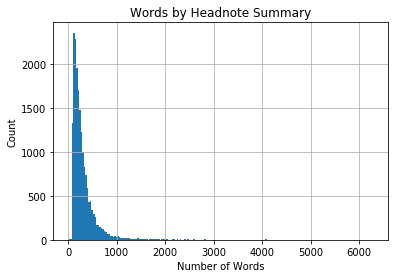

In [5]:
word_count = []
for i in clean_headnotes:
    word_count.append(len(i.split()))

length_df = pd.DataFrame({'Words by Headnote Summary':word_count})
length_df.hist(bins = 200)
plt.xlabel("Number of Words")
plt.ylabel("Count")
#plt.xlim((0, 300))
plt.show()

In [18]:
print("Shortest Headnotes: {} Words".format(min(word_count)))
print("Longest Headnotes: {} Words".format(max(word_count)))

Shortest Headnotes: 5 Words
Longest Headnotes: 6290 Words


Later, when seq2seq models are trained, headnotes need to be of similar length to standardize inputs. In order to stadardize headnotes length, Gensim's summarizer is applied to extract the most important sentences around 50 words from the headnotes, and are then stored in `clean_summaries`. These are used as target inputs for the seq2seq model.

In [21]:
# Extractive summary using gensim's TextRank implementation
clean_summaries = []
for i, tx in enumerate(clean_headnotes):
    try:
        summ = summarize(tx, word_count=50)
        if len(summ) < 10:
            clean_summaries.append(tx)
        else:
            clean_summaries.append(summ)
    except ValueError:
        clean_summaries.append(tx)

#### b) Preprocessing for Pretrained Models

Extractive summarization is also used to shorten case inputs for pre-trained models. The GPT-2 model, in particular, has a built-in maximum length of 1024 words per input. Gensim's summarizer is applied to shorten inputs by extracting only the most important sentences. Cases above 8000 words are also removed, because extraction took a very long time for those cases.

In [13]:
not_too_long = []
for i in clean_text:
    if len(i.split()) < 8000:
        not_too_long.append(i)

In [57]:
len(not_too_long)

18788

In [15]:
def gpt2_preprocess(text, max_words, tag='TL;DR:'):
    '''
    Returns shortened text based on Gensim's TextRank algorithm.
    Optionally tags texts for summarization in gpt2
    '''
    # Extractive summary of max_words words
    if len(text.split()) > max_words:
        short = summarize(text, word_count=max_words)
    else:
        short = text
    
    # Tag for summarization
    if tag != None:
        short = ' '.join((short, tag))
    
    return short

In [58]:
short_cases = [gpt2_preprocess(i, 500) for i in not_too_long]

CPU times: user 24min 46s, sys: 35 s, total: 25min 21s
Wall time: 15min 25s


In [59]:
with open(os.path.join('data', 'short_cases2.txt'), 'w') as f:
    for line in short_cases:
        f.write('%s\n' % line)

In [39]:
shortcases = []

with open(os.path.join('data', 'short_cases2.txt'), 'r') as f:
    shortcases.append(f.read().split('TL;DR:'))

In [40]:
shortcases = shortcases[0]

_________________________________

## IV) Abstractive Summarization

In Abstractive Summarization new sentences are generated to capture the meaning of the source document and hence is more complex as compared to the extractive approach. Abstractive techniques have the potential to produce human-like textual summaries, since it supposed to capture semantic representation, inference and implement natural language generation. This removes the constraints on the model to use pre-written text. Abstractive models do need large-scale domain specific data for training.

Word embeddings may need to be learned to capture semantical, hierarchical and contextual information from the source documents and may greatly impact the accuracy of an abstractive model. For this project GloVe Wikipedia 2014 + Gigaword 5 Word embeddings were used, since training custom word embedding for the Case Law data set would be resource- and time-intensive.

### Word Embeddings

Before building a word embeddings matrix, max sequence lengths must be determined and hyperprameters must be set. Max sequence lengths were set at 2500 for the input cases and 50 for the summaries, since the majority of cases were around those lengths or shorter.

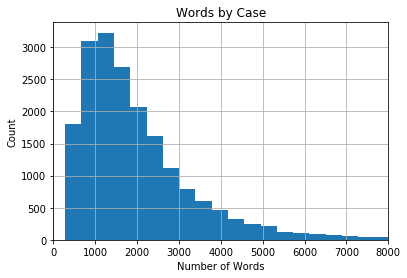

In [7]:
word_count = []
for i in clean_text:
    word_count.append(len(i.split()))

length_df = pd.DataFrame({'Words by Case':word_count})
length_df.hist(bins = 100)
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.xlim((0, 8000))
plt.show()

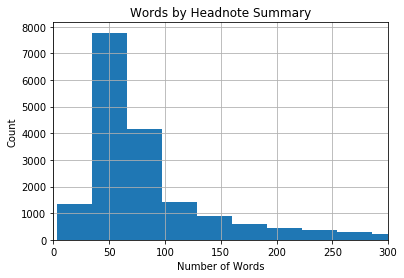

In [33]:
word_count = []
for i in clean_summaries:
    word_count.append(len(i.split()))

length_df = pd.DataFrame({'Words by Headnote Summary':word_count})
length_df.hist(bins = 200)
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.xlim((0, 300))
plt.show()

In [23]:
# Hyperparameters
MAX_CASE_LENGTH = 2500
VALIDATION_SPLIT = 0.1
EMBEDDING_DIM = 100
EMB_DIR = 'embeddings'
MAX_SUMMARY_LENGTH = 50
RANDOM_STATE = 109
GLOVE_FILE = 'glove.6B.{}d.txt'.format(EMBEDDING_DIM)

The data is split into train and test groups so that they can be set up data for embeddings:

In [24]:
# Split data into training and validation datasets
x_tr, x_val, y_tr, y_val = train_test_split(clean_text, 
                                            clean_summaries, 
                                            test_size=VALIDATION_SPLIT, 
                                            random_state=RANDOM_STATE, 
                                            shuffle=True)

A word tokenizer is then prepared to convert words to integer sequences and later embed them. Sequences are padded with zeroes at the end so that they are all the same length.

In [25]:
#prepare a tokenizer for cases on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts([i for i in x_tr])

#convert text sequences into integer sequences
x_tr = x_tokenizer.texts_to_sequences(x_tr) 
x_val = x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr = pad_sequences(x_tr,  maxlen=MAX_CASE_LENGTH, padding='post') 
x_val = pad_sequences(x_val, maxlen=MAX_CASE_LENGTH, padding='post')


#convert summary sequences into integer sequences
y_tr = x_tokenizer.texts_to_sequences(y_tr)
y_val = x_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr = pad_sequences(y_tr, maxlen=MAX_SUMMARY_LENGTH, padding='post')
y_val = pad_sequences(y_val, maxlen=MAX_SUMMARY_LENGTH, padding='post')

In [26]:
word_index = x_tokenizer.word_index
index_word = x_tokenizer.index_word

vocab_size = len(word_index)+1

index_word[0] = 'ENDPAD'
word_index['ENDPAD'] = 0

An embedding matrix is then created based on <a href="http://nlp.stanford.edu/data/wordvecs/glove.6B.zip">GloVe Wikipedia 2014 + Gigaword 5</a> embeddings.

In [27]:
# Preparing Embedding Layer
# GloVe Wikipedia 2014 + Gigaword 5 embeddings
# from http://nlp.stanford.edu/data/wordvecs/glove.6B.zip

embeddings_index = {}
f = open(os.path.join(EMB_DIR, GLOVE_FILE))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [28]:
# Build embedding matrix
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Finally, a Keras `embedding_layer` containing these word embedding weights is built.

In [29]:
embedding_layer = Embedding(vocab_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_CASE_LENGTH,
                            trainable=False)

-----------

### Models

#### 1) Seq2Seq Model

One of the most popular deep-learning algorithms used for natural language processing is Seq2Seq. This methodology uses recurrent neural networks containing one encoder and one decoder. In this model, the encoder network accepts case law text as input, creates word embeddings using the previously-created Keras `embedding_layer`, and passes those through an LSTM. The decoder network accepts the encoder output as its input, and itself outputs summary text, word by word, based on the word it determines is most likely to come next. The existing summary text is repeatedly fed back into the decoder along with the latent space output of the text encoder, and those inputs are passed through the decoder to calculate each successive word.  

A diagram of the general structure of the model used can be seen <a href="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/09/Alternate-3-Recursive-Text-Summarization-Model-B.png">below</a>:

In [55]:
Image(url= "https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/09/Alternate-3-Recursive-Text-Summarization-Model-B.png")

The model, adapted from "Recursive Model B" from <a href="https://machinelearningmastery.com/encoder-decoder-models-text-summarization-keras/">this site</a>, is instantiated and compiled, then trained for 5 epochs.

In [68]:
# Adapted from "Alternate 3: Recursive Model B"
# from https://machinelearningmastery.com/encoder-decoder-models-text-summarization-keras/
# article input model
inputs1 = Input(shape=(MAX_CASE_LENGTH,), name='input1')

article1 = embedding_layer(inputs1)
article2 = LSTM(EMBEDDING_DIM)(article1)
article3 = RepeatVector(MAX_SUMMARY_LENGTH)(article2)

# summary input model
inputs2 = Input(shape=(MAX_SUMMARY_LENGTH,), name='input2')
summ1 = embedding_layer(inputs2)

# decoder model
decoder1 = concatenate([article3, summ1])
decoder2 = LSTM(EMBEDDING_DIM, return_sequences=True)(decoder1)
outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder2)

# tie it together [article, summary] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs, name="Headnotes")
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
model.summary()

Model: "Headnotes"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None, 2500)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             13642700    input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 100)          80400       embedding[0][0]                  
__________________________________________________________________________________________________
input2 (InputLayer)             [(None, 50)]         0                                    

In [4]:
history=model.fit([x_tr,y_tr], y_tr,
                  epochs=5,batch_size=256, 
                  validation_data=([x_val,y_val], y_val))

In [69]:
# Saved weights
model.load_weights("weights/on_headnotes")

# Other model weights
#model.load_weights("weights/model_recursive")
#model.load_weights("weights/glove_recursive")

#### Prediction

After the model is trained, a function is built to produce summary predictions based on the model. In this particular case, the prediction function is told to skip over stopwords. Since stopwords are so common, they are often identified as "most likely" words even when not appropriate.

In [71]:
def seq2seq_prediction(case_idx, max_len=MAX_CASE_LENGTH, max_sum_len=MAX_SUMMARY_LENGTH):
    '''
    Function to output predicted summary.
    
    case_idx is index for predicted case.
    
    max_len and max_sum_len are hyperparameters
    '''
    # Set up input and target sequences
    input_seq = x_val[case_idx].reshape(1, max_len)
    target_seq = np.zeros((1, max_sum_len))
    
    # Stopwords from nltk
    stop_words = set(stopwords.words('english'))

    sentence = []

    for i in range(max_sum_len):
        
        # Predict likelihood of each word
        pred = model.predict([input_seq, target_seq])
        
        # Choose next likeliest word if it is a stopword
        stopword = True
        ind = 0
        while stopword:
            sampled_token_index = np.argsort(-pred[0, i, :])[ind]+1
            ind += 1
            word = index_word[sampled_token_index]
            if word not in stop_words:
                if (i == 0 or word != sentence[i-1]):
                    stopword = False
        
        sentence.append(word)
        target_seq[0, i] = sampled_token_index

    return ' '.join([i for i in sentence])

Summary predictions are printed for 3 cases.

In [73]:
for i in range(1,4):
    print(seq2seq_prediction(i))
    print()

defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial

defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial

defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defendant trial defend

These predictions do not even come close to coherent sentences, let alone anything resembling a case summary.  

There are two major, apparent issues with these predictions, which both stem from the same set of model limitations. The first issue is that the words "defendant" and "trial" are just repeated over and over again. The model has identified these as the most likely next words, regardless of the context of the existing summary text that gets repeatedly input into the model. The prediction function manually ensures that no single word is repeated one after the other, but it does not ensure that words do not repeat alternately.  

The second major issue is that the predictions are exactly the same, regardless of the input text. Any case input into the model will have a predicted summary of "defendant trial defendant trial... etc".  

The Seq2Seq model works by predicting the most likely next summary word, given an input text and the existing summary sequence. Clearly, this model is grossly over-generalized. There are various ways to improve this model, including:
- Increasing training data size
- Increasing layer parameters
- Adding additional hidden LSTM layers
- (And most importantly) Increasing training time

As it is, the Seq2Seq model took 5-10 hours to train. To improve the model to anything resembling coherency, training time would likely increase exponentially. Given the time and resources allocated for this project, attempts to train an adequate model were put on hold. Instead, focus was shifted to testing and optimizing existing, pre-trained models.

--------------
#### 2) Pretrained Model: BertSum

<a href = https://arxiv.org/abs/1903.10318>BertSum</a> is a pre-trained text summarization model on the <a href=https://cs.nyu.edu/~kcho/DMQA/>CNN/Daily Mail</a> news text corpus. BertSum uses a greedy method to select sentences which can maximize ROUGE scores in comparison to the baseline summaries. BertSum scores the sentences' representativeness of the source document and uses high-scoring sentences for document summarization.

BertSum is a modification of BERT, which is a pretrained language model focused on tokens/words rather than sentences. Since sentence representation is necessary for text summarization tasks, BERT is modified to capture features and representations of each sentence and to distinguish multiple sentences along with their hierarchy in the source document.

One of the drawbacks for using BertSum for Case Law is the fact that it is trained on news text and may not contain the semantics and contextual essence of legal documentation.

To process the data using BertSum, nlpyang's <a href=https://github.com/nlpyang/PreSumm>PreSumm</a> pipeline is used.

In [ ]:
#!git clone https://github.com/mingchen62/PreSumm.git

In [ ]:
# !gdown https://drive.google.com/uc?id=1kKWoV0QCbeIuFt85beQgJ4v0lujaXobJ&export=download #CNN/DM Extractive bertext_cnndm_transformer.pt

# Downloaded/unzipped locally
# !gdown https://drive.google.com/uc?id=1-IKVCtc4Q-BdZpjXc4s70_fRsWnjtYLr&export=download #CNN/DM Abstractive model_step_148000.pt 

# !unzip models/bertsumextabs_cnndm_final_model.zip

# !mkdir PreSumm/models/CNN_DailyMail_Abstractive
# !mv models/model_step_148000.pt models/CNN_DailyMail_Abstractive

In [44]:
os.remove(os.path.join(d_path, 'case1.txt'))

In [45]:
d_path = 'PreSumm/bert_data/cnndm'

with open(os.path.join(d_path, 'case1.txt'), 'w') as f:
    f.write(shortcases[5])

BertSum is then executed from command line to generate summaries.

In [102]:
!python3 summarizer.py -task abs -mode test -test_from ../models/CNN_DailyMail_Abstractive/model_step_148000.pt -batch_size 32 -test_batch_size 500 -bert_data_path ../bert_data/cnndm -log_file ../logs/val_abs_bert_cnndm -report_rouge False  -sep_optim true -use_interval true -visible_gpus -1 -max_pos 512 -max_src_nsents 100 -max_length 50 -alpha 0.95 -min_length 20 -result_path ../results/abs_bert_cnndm_sample

In [47]:
summ_file = 'PreSumm/results/abs_bert_cnndm_sample.148000.candidate'
summ_path = 'BertSum_Summaries'

with open(summ_file, 'r') as f:
    with open(os.path.join(summ_path, 'summary5.txt'), 'w') as g:
        g.write(f.read())

In [93]:
# Remove ipynb checkpoints folder if necessary
ipath = os.path.join(summ_path, '.ipynb_checkpoints')
for file in os.listdir(ipath):
    os.remove(os.path.join(file, ipath))
os.rmdir(ipath)

In [48]:
filenames = []
for i in range(1,6):
    filenames.append('summary{}.txt'.format(i))

BertSum summaries of the first five cases are printed out to verify coherency.

In [97]:
summ_path = 'BertSum_Summaries'

BertSum_summaries = []
for i, file in enumerate(filenames):
    with open(os.path.join(summ_path, file)) as f:
        BertSum_summaries.append(f.read())
    print('BertSum Summary for Case # {}'.format(i+1))
    print(BertSum_summaries[i])

BertSum Summary for Case # 1
danny cevallos : the only question for review is the admissibility of letters and photographs seized by deputies of the onslow county sheriff 's department during search of the mobile home occupied by the defendants<q>he says the seizure of these letters and

BertSum Summary for Case # 2
the trial judge did not commit reversible error by permitting further examination and challenge of juror by the state after the jury was impaneled<q>mrs trogdon testified on voir dire that after she had seen defendant at the restaurant in september

BertSum Summary for Case # 3
the court of appeals upheld the use of formula known as the volume variation adjustment factor which provided for the yearly " true up " of natural gas in manner identical to that of the ctr<q>in the case , ncng can not know the actual rate

BertSum Summary for Case # 4
the dispositive question on this appeal is whether statements allegedly made to plaintiff by defendant 's agent rochelle were proper

-----------

#### 3) Pretrained Model: GPT-2

<a href=https://openai.com/blog/better-language-models/>GPT-2</a> is a state-of-the-art text generation model with the capability to produce long texts. GPT-2 uses auto-regression, meaning it outputs one word at a time, which is then appended at the end of the input words to create a new input sequence to generate the next word output. 

GPT-2 uses an extremely large number of parameters and is trained on millions of web pages. Due to this diversity the expectation is that GPT-2 is capable of generating text with human level accuracy and quality.

GPT-2 also has a text summarization feature. For this project, two major limitations were observed duirng its implementation. The first limitation is that the maximum number of input word tokens is set to 1024, whereas some cases have thousands of words. To deal with this, Gensim's extractive summarizer was leveraged (see "Extractive Summarization" section 2b) to reduce cases to their most important sentences. 

The second limitation is that the GPT-2 summarizer model is, in many cases, prone to repeating phrases and/or sentences.

These limitations can be mitigated by training a new model with custom configurations, including increasing the maximum number of tokens, and setting a "temperature" parameter to decrease the likelihood of repetition. In future work, this could enhance the usability and performance of the model. 

In [56]:
def gpt2_summarize(case, max_summ_len=50):
    '''
    Uses gpt2 to implement abstractive summarization
    '''
    # Instantiate tokenizer and model from pre-trained GPT2
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    model = GPT2LMHeadModel.from_pretrained('gpt2')

    # Tokenize text and convert to tensor
    generated = []
    input_ids = tokenizer.encode(case, add_special_tokens=True)
    context = torch.tensor([input_ids]).unsqueeze(0)
    past = None

    # Generate summary words iteratively
    for i in range(max_summ_len):
        output, past = model(context, past=past)
        token = torch.argmax(output[..., -1, :])

        generated += [token.tolist()]
        context = token.unsqueeze(0)
    
    # Reverse-tokenize generated sentence
    sequence = tokenizer.decode(generated)

    # Return first sentence
    return sequence.split('.')[0]

In [49]:
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

gpt2_summaries = []

for i in range(1,6):
    try:
        summary = gpt2_summarize(' '.join((clean_text[i], 'TL;DR:')))
    except:
        summary = gpt2_summarize(' '.join((shortcases[i], 'TL;DR:')))
    gpt2_summaries.append(summary)

In [66]:
gpt2_path = 'gpt2_summaries'
for i, summ in enumerate(gpt2_summaries):
    with open(os.path.join(gpt2_path, filenames[i]), 'w') as f:
        f.write(summ)

Five cases of GPT-2 generated summaries were printed to verify if they are coherent.

In [68]:
for i, file in enumerate(filenames):
    with open(os.path.join(gpt2_path, file)) as f:
        print('GPT2 Summary for Case # {}'.format(i+1))
        print(f.read())
        print()

GPT2 Summary for Case # 1
 The Court of Appeals for the Ninth Circuit, in its opinion, held that the search of the mobile home of the defendants was not per se unreasonable under the Fourth Amendment

GPT2 Summary for Case # 2
 The State was not required to prove the charge of rape in order to convict defendant of burglary

GPT2 Summary for Case # 3

The Court of Appeals held that the Commission's decision to reduce the amount of the “true up” of NCNG's past undercollection by NCNG was not change in fixed general rate, and therefore the Commission's decision to reduce the

GPT2 Summary for Case # 4
 The majority's opinion is correct

GPT2 Summary for Case # 5
 The trial judge stated that the defendant was not entitled to counsel during the sentencing phase



-------

#### Data Augmentation with Blackstone

One of the issues with using pre-trained models for case law is that those models are trained on a wide array of corpuses, while case law uses very specific and often unique language. A potential method of mitigating this is through data augmentation. If certain elements within the input texts are weighted higher, it is possible that pre-trained models will identify them as more important and incorporate that into their outputs.  

<a href=https://github.com/ICLRandD/Blackstone>Blackstone</a> is a legal NLP tool developed by the Incorporated Council of Law Reporting for England and Wales. More specifically, it is "a spaCy model and library for processing long-form, unstructured legal text." The model is designed to accept legal texts as inputs, and output classifications for each sentence as one of the following:

| Category | Description |
| --- | --- |
| AXIOM	| The text appears to postulate a well-established principle |
| CONCLUSION | The text appears to make a finding, holding, determination or conclusion |
| ISSUE	| The text appears to discuss an issue or question |
| LEGAL_TEST | The test appears to discuss a legal test |
| UNCAT | The text does not fall into one of the four categories above |
  
In this section, Blackstone is leveraged to identify important sentences in legal texts. Once important sentences are identified, case texts can be augmented either by filtering only important sentences, or by repeating sentences with specific category tags.

The Blackstone model is loaded through spaCy.

In [44]:
model_name = "en_blackstone_proto"
package_path = get_package_path(model_name)
link(model_name, model_name, force=True, model_path=package_path)

✔ Linking successful
/usr/share/anaconda3/lib/python3.7/site-packages/en_blackstone_proto -->
/usr/share/anaconda3/lib/python3.7/site-packages/spacy/data/en_blackstone_proto
You can now load the model via spacy.load('en_blackstone_proto')


In [45]:
nlp = spacy.load('en_blackstone_proto')

A pipeline is created to process legal texts and output the most likely tag for each sentence, plus a confidence level for the most likely tags.

In [46]:
from blackstone.pipeline.abbreviations import AbbreviationDetector
from blackstone.pipeline.compound_cases import CompoundCases
from blackstone.pipeline.sentence_segmenter import SentenceSegmenter
from blackstone.rules import CITATION_PATTERNS

# Add tools to blackstone pipeline
abbreviation_pipe = AbbreviationDetector(nlp)
nlp.add_pipe(abbreviation_pipe)

compound_pipe = CompoundCases(nlp)
nlp.add_pipe(compound_pipe)

sentence_segmenter = SentenceSegmenter(nlp.vocab, CITATION_PATTERNS)
nlp.add_pipe(sentence_segmenter, before="parser")

def ents_cats(case):
    """
    Function to identify entities in text and the highest scoring category
    prediction generated by the text categoriser. 
    """
    doc = nlp(case)
    
    # Identify entities in text
    entities = dict()
    for ent in doc.ents:
        entities[ent.text] = [ent.label_]
    
    # Identify most likely category, with score
    sentences = [sent.text for sent in doc.sents]
    categories = dict()
    for sentence in sentences:
        doc = nlp(sentence)
        cats = doc.cats
        score_list = sorted(list(cats.values()), reverse=True)
        max_score = score_list[0]
        second_score = score_list[1]
        max_cats = [k for k, v in cats.items() if v == max_score]
        max_cat = max_cats[0]
        second_cats = [k for k, v in cats.items() if v == second_score]
        second_cat = second_cats[0]
        categories[sentence] = (max_cat, np.round(max_score, decimals=3)), (second_cat, np.round(second_score, decimals=3))
    
    return entities, categories

In [47]:
_, cats = ents_cats(clean_text[1])

Unfortunately, this model is not particularly effectve for this project's dataset. In the case printed below, for example, every sentence is predicted as UNCAT with a relatively high degree of confidence. This issue may be due to the fact that Blackstone was trained on UK legal texts, while the cases used in this project are all from the US. Blackstone therefore cannot be relied upon for this project.

In [48]:
for k, v in cats.items():
    print(k)
    print(v)
    print()

The sole question for review by this Court is the admissibility of letters and photographs seized by deputies of the Onslow County Sheriff’s Department during search of the mobile home occupied by the defendants.
(('UNCAT', 0.621), ('ISSUE', 0.361))

The deputies searched the mobile home pursuant to validly issued “occupant warrant” which specified heroin as the object of the search.
(('UNCAT', 0.998), ('CONCLUSION', 0.001))

From the trailer’s bathroom, substance later determined to be heroin was seized, and after the heroin was discovered, letters and photographs which had been seen earlier were also taken from the adjoining bedroom.
(('UNCAT', 0.997), ('CONCLUSION', 0.002))

For the reasons which follow, we hold that the letters and photographs, though not specifically listed on the warrant as objects of the search, were properly seized and admitted into evidence.
(('UNCAT', 0.914), ('CONCLUSION', 0.079))

In Katz United States, Ed.
(('UNCAT', 1.0), ('ISSUE', 0.0))

Ct.
(('UNCAT', 1

----------

## V) Model Evaluation

### 1) ROUGE Scores

Recall-Oriented Understudy for Gisting Evaluation or <a href=https://en.wikipedia.org/wiki/ROUGE_(metric)>ROUGE</a> is a set of metrics used to score the accuracy of text summarization through machine learning by comparing them with human generated references or "Gold-Standard" summaries. ROUGE consists of the following 3 scoring methodologies:

1. ROUGE-1: Unigram overlap between the baseline and ML generated summaries
2. ROUGE-2: Bigram overlap between the baseline and ML generated summaries
3. ROUGE-L: Longest occurring sequence in both baseline and ML generated summaries.

ROUGE does not quantify the fluency of the summary but rather assesses the adequacy through counting the number of n-grams in the ML generated summary that are also present in the original source document. Hence it largely depends on the human-inscribed baseline or gold standard summary text.

The case document headnotes provided for this project lacks the brevity and simplicity required for a gold standard baseline. Therefore, to test the summaries empirically, the project team penned down 5 case summaries as human-generated gold standard summaries.

In addition to standard F1 scores (or 'f'), ROUGE also calculates the following two metrics:

p - Precision: measures ML generated summary relevancy. 

r - Recall: measures the extent of baseline or gold standard summary is being captured by ML generated summary.

In [70]:
goldnames = ['gold_{}.txt'.format(i) for i in range(1,6)]

In [73]:
gold_path = 'gold_summaries'

The gold standard summaries for the first 5 cases are as follows:

In [149]:
# Gold-standard summaries
gold_summaries = []
for i, file in enumerate(goldnames):
    with open(os.path.join(gold_path, file)) as f:
        gold_summaries.append(f.read())
    print('Gold-Standard Summary for Case # {}'.format(i+1))
    print(gold_summaries[i])
    print()


Gold-Standard Summary for Case # 1
The opinion of the Court of Appeals is reversed, the judgment of the trial court is affirmed, and this cause is remanded to the Court of Appeals.

Gold-Standard Summary for Case # 2
Defendant plea to declare a miss-trial due to trial court Judge miss-conduct and violation of defendant’s constitutional rights was over-ruled after Court’s consideration of the entire record in which no error were found warranting new trial.

Gold-Standard Summary for Case # 3
Court of Appeals affirmed the decision of the Commission to allow roll in of the past under collection during the prior year to offset an over collection during the following annual period.

Gold-Standard Summary for Case # 4
For the reasons stated the decision of the Court of Appeals as it relates to Southern Bell is reversed.

Gold-Standard Summary for Case # 5
Defendant plea that due process of law was denied was rejected by the Court, as it observed that defendant sentencing hearing was properly

Average ROUGE-1, ROUGE-2 and ROUGE-l scores were calculated for the Gensim, BertSum and GPT-2 summaries.

In [155]:
from rouge import Rouge

rouge = Rouge()
scores_gen = rouge.get_scores(gensim_summaries, gold_summaries, avg=True)
scores_bert = rouge.get_scores(BertSum_summaries, gold_summaries, avg=True)
scores_gpt2 = rouge.get_scores(gpt2_summaries, gold_summaries, avg=True)

ROUGE 1 (Unigram): GPT-2 has the highest score as compared to the other two models, though recall seems to be higher in Gensim as compared to GPT2. This could be due to the extractive nature of Gensim summary.

In [156]:
print("Average ROUGE-1 Scores for Each Model (Over 5 Cases):")

pd.DataFrame({"Gensim": scores_gen['rouge-1'], "BertSum": scores_bert['rouge-1'], "GPT2": scores_gpt2['rouge-1']})

Average ROUGE-1 Scores for Each Model (Over 5 Cases):


,Gensim,BertSum,GPT2
f,0.206432,0.210068,0.272178
p,0.168618,0.176026,0.336241
r,0.308444,0.268419,0.253603


ROUGE 2 (Bigram): Gensim is ranked higher than the other two models, possibly due to the extractive summarization causing a higher overlap of bigrams with baseline summaries.

In [153]:
print("Average ROUGE-2 Scores for Each Model (Over 5 Cases):")

pd.DataFrame({"Gensim": scores_gen['rouge-2'], "BertSum": scores_bert['rouge-2'], "GPT2": scores_gpt2['rouge-2']})

Average ROUGE-2 Scores for Each Model (Over 5 Cases):


,Gensim,BertSum,GPT2
f,0.047046,0.017203,0.046218
p,0.041223,0.014201,0.042883
r,0.063662,0.021836,0.050124


ROUGE l (Longest Sequence): GPT2 scored higher than the other two models, though Gensim again scored highest in the recall metric.

In [157]:
print("Average ROUGE-l Scores for Each Model (Over 5 Cases):")

pd.DataFrame({"Gensim": scores_gen['rouge-l'], "BertSum": scores_bert['rouge-l'], "GPT2": scores_gpt2['rouge-l']})

Average ROUGE-l Scores for Each Model (Over 5 Cases):


,Gensim,BertSum,GPT2
f,0.137041,0.133738,0.181614
p,0.117773,0.112548,0.220833
r,0.196311,0.173070,0.177042


### 2) Intuitive Evaluation

Though ROUGE scores are extremely useful in many contexts, they rely on strict adherence to sentence length and reproducability of ngrams, and cannot necessarily judge how well a summary captures the essence of a text. For the 5 cases evaluated with ROUGE, an intuitive look at the various summaries shows how summaries with higher ROUGE scores are not neccesarily "better" summaries.  

For each of the 5 cases, the Gold-Standard (human) summary is printed out, followed by the Gensim, BertSum and GPT-2 summaries. Observations are then made comparing the summaries.

In [139]:
i=0
print('Gold-Standard Summary for Case # {}'.format(i+1))
print(gold_summaries[i])
print()
print('Gensim Extractive Summary for Case # {}'.format(i+1))
print(gensim_summaries[i])
print()
print('BertSum Summary for Case # {}'.format(i+1))
print(BertSum_summaries[i])
print()
print('GPT2 Summary for Case # {}'.format(i+1))
print(gpt2_summaries[i])

Gold-Standard Summary for Case # 1
The opinion of the Court of Appeals is reversed, the judgment of the trial court is affirmed, and this cause is remanded to the Court of Appeals.

Gensim Extractive Summary for Case # 1
searches conducted outside the judicial process, without prior approval by judge or magistrate, are per se unreasonable under the Fourth Amendment subject only to few specifically established and well-delineated exceptions We are of the opinion that the seizure of these letters and photographs which were not listed on the face of the warrant and therefore seized without prior judicial approval, was proper as coming within just such well-delineated exception; that of “plain view The “plain view” exception was discussed by the United States Supreme Court in Coolidge New Hampshire, Ed. Ct.

BertSum Summary for Case # 1
danny cevallos : the only question for review is the admissibility of letters and photographs seized by deputies of the onslow county sheriff 's department

**Case 1 Observation:** Gensim provides a very good summary, despite its low ROUGE score.

In [140]:
i=1
print('Gold-Standard Summary for Case # {}'.format(i+1))
print(gold_summaries[i])
print()
print('Gensim Extractive Summary for Case # {}'.format(i+1))
print(gensim_summaries[i])
print()
print('BertSum Summary for Case # {}'.format(i+1))
print(BertSum_summaries[i])
print()
print('GPT2 Summary for Case # {}'.format(i+1))
print(gpt2_summaries[i])

Gold-Standard Summary for Case # 2
Defendant plea to declare a miss-trial due to trial court Judge miss-conduct and violation of defendant’s constitutional rights was over-ruled after Court’s consideration of the entire record in which no error were found warranting new trial.

Gensim Extractive Summary for Case # 2
In that case, the Court held that the trial judge did not commit reversible error by permitting further examination and challenge of juror by the State after the jury was impaneled, when it was discovered that the juror worked with the wife of one of the defendants.

BertSum Summary for Case # 2
the trial judge did not commit reversible error by permitting further examination and challenge of juror by the state after the jury was impaneled<q>mrs trogdon testified on voir dire that after she had seen defendant at the restaurant in september


GPT2 Summary for Case # 2
 The State was not required to prove the charge of rape in order to convict defendant of burglary


**Case 2 Observation:** Though GPT-2 has the highest ROUGE scores, its summary draws from some intermediate context of the text, and not from its conclusion.

In [141]:
i=2
print('Gold-Standard Summary for Case # {}'.format(i+1))
print(gold_summaries[i])
print()
print('Gensim Extractive Summary for Case # {}'.format(i+1))
print(gensim_summaries[i])
print()
print('BertSum Summary for Case # {}'.format(i+1))
print(BertSum_summaries[i])
print()
print('GPT2 Summary for Case # {}'.format(i+1))
print(gpt2_summaries[i])

Gold-Standard Summary for Case # 3
Court of Appeals affirmed the decision of the Commission to allow roll in of the past under collection during the prior year to offset an over collection during the following annual period.

Gensim Extractive Summary for Case # 3
We have concluded, however, that rate adjustment pursuant to an annual CTR “true up” is not change in fixed general rate, and thus the rate adjustment in this case which allowed NCNG to offset its overcollection by its previous undercollection does not *constitute retroactive rate making prohibited by Utilities Commission Edmisten, E.

BertSum Summary for Case # 3
the court of appeals upheld the use of formula known as the volume variation adjustment factor which provided for the yearly " true up " of natural gas in manner identical to that of the ctr<q>in the case , ncng can not know the actual rate


GPT2 Summary for Case # 3

The Court of Appeals held that the Commission's decision to reduce the amount of the “true up” of 

**Case 3 Observation:** Gensim and BertSum provide fair summaries, while GPT-2 does not capture the essence of the text.

In [142]:
i=3
print('Gold-Standard Summary for Case # {}'.format(i+1))
print(gold_summaries[i])
print()
print('Gensim Extractive Summary for Case # {}'.format(i+1))
print(gensim_summaries[i])
print()
print('BertSum Summary for Case # {}'.format(i+1))
print(BertSum_summaries[i])
print()
print('GPT2 Summary for Case # {}'.format(i+1))
print(gpt2_summaries[i])

Gold-Standard Summary for Case # 4
For the reasons stated the decision of the Court of Appeals as it relates to Southern Bell is reversed.

Gensim Extractive Summary for Case # 4
“Authority to do an act on the principal’s behalf does not ordinarily carry with it an implied authority to talk about it afterwards Stansbury, supra, at [] Application of the above principles to the facts in this case leads us to conclude that the statements allegedly made to plaintiff by defendant’s agent, Rochelle, were erroneously admitted into evidence.

BertSum Summary for Case # 4
the dispositive question on this appeal is whether statements allegedly made to plaintiff by defendant 's agent rochelle were properly admissible into evidence as the admissions of southern bell<q>if there is no competent evidence that an agent has authority to speak for his


GPT2 Summary for Case # 4
 The majority's opinion is correct


**Case 4 Observation:** Gensim generated a great summary. BertSum simply printed out the first two sentences of the text. The GPT-2 summary is too general and uninformative.

In [158]:
i=4
print('Gold-Standard Summary for Case # {}'.format(i+1))
print(gold_summaries[i])
print()
print('Gensim Extractive Summary for Case # {}'.format(i+1))
print(gensim_summaries[i])
print()
print('BertSum Summary for Case # {}'.format(i+1))
print(BertSum_summaries[i])
print()
print('GPT2 Summary for Case # {}'.format(i+1))
print(gpt2_summaries[i])

Gold-Standard Summary for Case # 5
Defendant plea that due process of law was denied was rejected by the Court, as it observed that defendant sentencing hearing was properly conducted and had a fair trial free from prejudicial error.

Gensim Extractive Summary for Case # 5
[] Defendant’s first argument is that he was denied due process of law when the trial judge refused to grant him an evidentiary *hearing upon his motion to dismiss all of the charges.

BertSum Summary for Case # 5
defense counsel produced statistics tending to show that other defendants had charges dismissed when the prosecuting witness so desired<q>if these statistics alone were enough to establish denial of equal protection , mandatory rule would be created requiring the district attorney to dismiss charges in all cases where


GPT2 Summary for Case # 5
 The trial judge stated that the defendant was not entitled to counsel during the sentencing phase


**Case 5 Observation:** Gensim generated an argument from the middle of the case document as the summary rather than the conclusion.  BertSum and GPT-2 both generated information that cannot be considered case summaries.

----------

## VI) Conclusion and Further Study

#### Model Successes and Limitations

*i. Seq2Seq*

The Seq2Seq model was the least successful of the attempted methods. Due to limitations in time and resources, adequate training time could not be allocated to produce a model that generates coherent predicitons.

*ii. Gensim Extractive Summarization*

Overall, while many of the Gensim extractive summaries successfully identified the most important sentences, they did present some limitations, particularly those mentioned at the beginning of section III. In particular, some Gensim summaries were observed to have included some irrelevant parts of text while omitting other important parts.  

*iii. BertSum*

BertSum succeeded, for the most part, in generating coherent sentences. However, it was extremely inconsistent in terms of capturing the essence of the text vs. summarizing less important (or even conflicting) areas of the text. This is likely due to the fact that the model is trained exclusively on news text from CNN and Daily Mail, as opposed to texts more similar to North Carolina case law.  

*iv. GPT-2*

GPT-2 was also extremely hit-or-miss. While its more successful summaries almost perfectly captured the essence of the text succinctly and comprehensively, some summaries were either far too general or missed the most important aspects of the text. This is likely because of how general the training data is for GPT-2, combined with its configuration limitations (including max word count and temperature).

#### Limitations in Evaluation

One of the most difficult parts of this project was determining a viable (let alone scalable) evaluation method for summaries. Though ROUGE scores are useful in some contexts, they failed to adequately measure how well the summaries captured the essence of the cases. This was compounded by the fact that ROUGE scores could only be calculated for 5 cases, since only 5 Gold-Standard summaries could be compiled. Ideally, Gold-Standard summaries would be created by humans for ALL available cases. These humans should have some baseline of legal expertise in order to confidently capture the essence of each legal text.

#### Recommendations

Between the modelling approaches used, extractive summarization with Gensim provided the best combination of accuracy, coverage and consistency. It could prove useful for searching through or filtering cases, or getting a general idea of a case's contents. However, the model is not specifically trained for legal text. Furthermore, the nature of extractive summarization means that the summaries are simply pieces of the text that are deemed "most" important, but there could be other parts of the text that are not included that are important as well. It is therefore recommended that these summaries be relied upon only as a helpful tool, and not for drawing any conclusions about the context or scope of the case itself. It is very likely that a fully-trained GPT-2 model on the legal corpus could produce more reliable and comprehensive results.

#### Next Steps

To improve the case law summarization to an adequate level the following steps needs to be taken.

i. *Gold Standard Summaries:*   

The models may need to be trained on case law documents which have succinct and accurate summaries transcribed by humans to be used as the gold standard. This will help the models to learn the specific semantics and contextual and hierarchical features of the legal documents.

ii. *Extractive versus Abstractive approach:*  


Since extractive summarization models are relatively simplistic, it may be prudent to look into enhancing an extractive pre-trained model to generate case law summaries in first phase. BertSum may be fine-tuned to generate extractive summaries. 
  
For abstractive summarization there may be a need to investigate Google’s T5 which is one of the most advanced NLP pre-trained models. One key feature contrast with BERT, an encoder blocks dominated model, and GPT-2, which primarily consists of decoder blocks, is that T5 uses both. T5 is trained on a 7TB dataset and supposedly can generate multiple versions of text summarization from the same source text with varying vocabulary and complexity.

iii. *Seq2Seq Model*:

Given more time and computational resources, a Seq2Seq model could be trained using more data, more parameters, a more complex network and could train for a longer period of time. This could potentially yield usable results.

-------------

## VII) References

**Case Law Dataset from Caselaw Access Project**  
https://case.law/

**Gensim Extractive Summarizer**  
https://radimrehurek.com/gensim/summarization/summariser.html

**TextRank Algorithm**  
https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf

**GloVe Wikipedia 2014 + Gigaworld 5 Embeddings**  
https://github.com/stanfordnlp/GloVe

**Seq2Seq Architectures**  
https://machinelearningmastery.com/encoder-decoder-models-text-summarization-keras/

**BertSum**  
https://arxiv.org/abs/1903.10318

**CNN/Daily Mail Dataset**  
https://cs.nyu.edu/~kcho/DMQA/

**PreSumm Implementation of BertSum**  
https://github.com/nlpyang/PreSumm

**Blackstone Legal Text Categorization**  
https://github.com/ICLRandD/Blackstone

**GPT-2**  
https://openai.com/blog/better-language-models/

**HuggingFace GPT-2 Implementation**  
https://huggingface.co/transformers/model_doc/gpt2.html

**ROUGE Score Summary Evaluation**  
https://www.aclweb.org/anthology/W04-1013/